In [2]:
print('hello world')

hello world


In [3]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

# set logging level to info
import logging
logging.basicConfig(level=logging.INFO)

from datasets_code import build_dataloader, build_dataset
from utils.options import parse_options
from train import create_train_val_dataloader
import torch
import numpy as np

import os
os.chdir('/home/s94zalek/shape_matching')

# print current working directory
print(os.getcwd())

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/home/s94zalek/shape_matching


In [4]:
import os

# root_path = osp.abspath(osp.join(__file__, osp.pardir))
root_path = '/home/s94zalek/shape_matching'

opt = parse_options(root_path, is_train=False, use_argparse=False,
                    opt_path = 'options/train/faust.yaml')

opt['root_path'] = root_path
opt['dist'] = False

opt['datasets']['train_dataset']['return_corr'] = True
opt['datasets']['train_dataset']['return_dist'] = False
opt['datasets']['test_dataset']['return_dist'] = False

# create train and validation dataloaders
result = create_train_val_dataloader(opt)
train_loader, train_sampler, val_loader, total_epochs, total_iters = result
train_dataset = train_loader.dataset

test_set = build_dataset(opt['datasets']['test_dataset'])
test_loader = build_dataloader(
test_set, opt['datasets']['test_dataset'], phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])


Backend DataParallel.
Path already exists. Rename it to /home/s94zalek/shape_matching/results/faust_archived_20240507_093239


Calculating functional maps: 100%|████████████████████████████████████████████████████████████████████████████| 6400/6400 [01:25<00:00, 74.95it/s]
2024-05-07 09:34:19,741 INFO: Dataset [PairFaustDataset]-[FaustTrain] is built.
Calculating functional maps: 100%|█████████████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 101.12it/s]
2024-05-07 09:34:26,473 INFO: Dataset [PairFaustDataset]-[FaustTest] is built.
Calculating functional maps: 100%|█████████████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 101.75it/s]
2024-05-07 09:34:31,127 INFO: Dataset [PairFaustDataset]-[FaustTest] is built.


In [5]:
Cxy_40 = []
Dx_40 = []
Dy_40 = []

Vxy_computed_40 = []
Rxy_computed_40 = []

data_40 = []

train_dataset = train_loader.dataset
for i in range(len(train_dataset)):
    data = train_dataset[i]
    if data['first']['name'] == 'tr_reg_040':
        
        Cxy_40.append(data['Cxy'])
        
        Dx_40.append(data['first']['evals'])
        Dy_40.append(data['second']['evals'])
        
        Vxy_computed_40.append(data['Vxy'])
        Rxy_computed_40.append(data['Rxy'])
        
        data_40.append(data)
        
Cxy_40_full = torch.stack(Cxy_40)
Cxy_40_truncated = torch.stack(Cxy_40)[:, :20, :20]

Dx_40_full = torch.stack(Dx_40)
Dy_40_full = torch.stack(Dy_40)

Vxy_computed_40_full = torch.stack(Vxy_computed_40)
Rxy_computed_40_full = torch.stack(Rxy_computed_40)

In [6]:
########################################################################################
# Check if difference operators in dataset are correct
########################################################################################

In [7]:
Cxy_T_Cxy_40_full = torch.bmm(Cxy_40_full.transpose(1, 2), Cxy_40_full)

Rxy_40_left = torch.bmm(
    torch.diag_embed(-1 / Dx_40_full),
    Cxy_40_full.transpose(1, 2)
    )
Rxy_40_right = torch.bmm(
    torch.diag_embed(-Dy_40_full),
    Cxy_40_full
    )

Rxy_40_full = torch.bmm(Rxy_40_left, Rxy_40_right)

In [8]:
print('Vxy in dataset - Vxy computed:', (Vxy_computed_40_full - Cxy_T_Cxy_40_full).sum())
print('Rxy in dataset - Rxy computed:', (Rxy_40_full - Rxy_computed_40_full).sum())

Vxy in dataset - Vxy computed: tensor(0.0002)
Rxy in dataset - Rxy computed: tensor(-6.4227e-05)


In [9]:
########################################################################################
#
# Descriptor preservation by GT Fmap
#
########################################################################################

In [10]:
data = data_40[21]
data_x = data['first']
data_y = data['second']

data_x['name'], data_y['name'], data['Cxy'].shape, data_x['evecs_trans'].shape, data_y['evecs'].shape

('tr_reg_040',
 'tr_reg_021',
 torch.Size([200, 200]),
 torch.Size([200, 5001]),
 torch.Size([5001, 200]))

In [11]:
# check wks/hks computation
# why the geodesic error is so high?
# put whs/hks to optimization problem
# initialize C properly, do not optimize 1st row (or column?)
# run optimization with V and R

In [12]:
import utils.geometry_util as geometry_util

# hks as descriptors
hks_x = geometry_util.compute_hks_autoscale(data_x['evals'].unsqueeze(0), data_x['evecs'].unsqueeze(0), 128)[0]
hks_y = geometry_util.compute_hks_autoscale(data_y['evals'].unsqueeze(0), data_y['evecs'].unsqueeze(0), 128)[0]

hks_pres_loss = (data['Cxy'] @ data_x['evecs_trans'] @ hks_x - data_y['evecs_trans'] @ hks_y).abs()

print('HKS preserv. loss,  50 ef, sum:', hks_pres_loss[:50, :50].sum(), 'mean:', hks_pres_loss[:50, :50].mean())
print('HKS preserv. loss, 100 ef, sum:', hks_pres_loss[:100, :100].sum(), 'mean:', hks_pres_loss[:100, :100].mean())
print('HKS preserv. loss, 150 ef, sum:', hks_pres_loss[:150, :150].sum(), 'mean:', hks_pres_loss[:150, :150].mean())
print('HKS preserv. loss, 200 ef, sum:', hks_pres_loss[:200, :200].sum(), 'mean:', hks_pres_loss[:200, :200].mean())

HKS preserv. loss,  50 ef, sum: tensor(99.7664) mean: tensor(0.0399)
HKS preserv. loss, 100 ef, sum: tensor(161.5919) mean: tensor(0.0162)
HKS preserv. loss, 150 ef, sum: tensor(184.0081) mean: tensor(0.0096)
HKS preserv. loss, 200 ef, sum: tensor(194.5981) mean: tensor(0.0076)


In [13]:
# wks as descriptors

wks_x = geometry_util.compute_wks_autoscale(data_x['evals'].unsqueeze(0), data_x['evecs'].unsqueeze(0), data_x['mass'].unsqueeze(0))[0]
wks_y = geometry_util.compute_wks_autoscale(data_y['evals'].unsqueeze(0), data_y['evecs'].unsqueeze(0), data_y['mass'].unsqueeze(0))[0]

wks_pres_loss = (data['Cxy'] @ data_x['evecs_trans'] @ wks_x - data_y['evecs_trans'] @ wks_y).abs()

print('WKS preserv. loss,  50 ef, sum:', wks_pres_loss[:50, :50].sum(), 'mean:', wks_pres_loss[:50, :50].mean())
print('WKS preserv. loss, 100 ef, sum:', wks_pres_loss[:100, :100].sum(), 'mean:', wks_pres_loss[:100, :100].mean())
print('WKS preserv. loss, 150 ef, sum:', wks_pres_loss[:150, :150].sum(), 'mean:', wks_pres_loss[:150, :150].mean())
print('WKS preserv. loss, 200 ef, sum:', wks_pres_loss[:200, :200].sum(), 'mean:', wks_pres_loss[:200, :200].mean())

WKS preserv. loss,  50 ef, sum: tensor(25.3663) mean: tensor(0.0101)
WKS preserv. loss, 100 ef, sum: tensor(77.3188) mean: tensor(0.0077)
WKS preserv. loss, 150 ef, sum: tensor(126.9926) mean: tensor(0.0066)
WKS preserv. loss, 200 ef, sum: tensor(149.6696) mean: tensor(0.0058)


In [14]:
########################################################################################
#
# Does this count as descriptor preservation?
# I guess it does
#
########################################################################################

In [15]:
import torch

Cxy_hks_lstsq = torch.linalg.lstsq(
    hks_x.T @ data_x['evecs_trans'].T,
    hks_y.T @ data_y['evecs_trans'].T
).solution.T

Cxy_wks_lstsq = torch.linalg.lstsq(
    wks_x.T @ data_x['evecs_trans'].T,
    wks_y.T @ data_y['evecs_trans'].T
).solution.T

print('Cxy_hks_lstsq error,  50 ef, sum:', (Cxy_hks_lstsq - data['Cxy']).abs()[:50, :50].sum(), 'mean:', (Cxy_hks_lstsq - data['Cxy']).abs()[:50, :50].mean())
print('Cxy_hks_lstsq error, 100 ef, sum:', (Cxy_hks_lstsq - data['Cxy']).abs()[:100, :100].sum(), 'mean:', (Cxy_hks_lstsq - data['Cxy']).abs()[:100, :100].mean())
print('Cxy_hks_lstsq error, 200 ef, sum:', (Cxy_hks_lstsq - data['Cxy']).abs().sum(), 'mean:', (Cxy_hks_lstsq - data['Cxy']).abs().mean())
print()
print('Cxy_wks_lstsq error,  50 ef, sum:', (Cxy_wks_lstsq - data['Cxy']).abs()[:50, :50].sum(), 'mean:', (Cxy_wks_lstsq - data['Cxy']).abs()[:50, :50].mean())
print('Cxy_wks_lstsq error, 100 ef, sum:', (Cxy_wks_lstsq - data['Cxy']).abs()[:100, :100].sum(), 'mean:', (Cxy_wks_lstsq - data['Cxy']).abs()[:100, :100].mean())
print('Cxy_wks_lstsq error, 200 ef, sum:', (Cxy_wks_lstsq - data['Cxy']).abs().sum(), 'mean:', (Cxy_wks_lstsq - data['Cxy']).abs().mean())

Cxy_hks_lstsq error,  50 ef, sum: tensor(147.0585) mean: tensor(0.0588)
Cxy_hks_lstsq error, 100 ef, sum: tensor(445.3884) mean: tensor(0.0445)
Cxy_hks_lstsq error, 200 ef, sum: tensor(1336.2449) mean: tensor(0.0334)

Cxy_wks_lstsq error,  50 ef, sum: tensor(284.5417) mean: tensor(0.1138)
Cxy_wks_lstsq error, 100 ef, sum: tensor(721.4183) mean: tensor(0.0721)
Cxy_wks_lstsq error, 200 ef, sum: tensor(1708.9946) mean: tensor(0.0427)


In [16]:
Cxy_hks_lstsq_50 = torch.linalg.lstsq(
    hks_x.T[:50, :] @ data_x['evecs_trans'].T[:, :50],
    hks_y.T[:50, :] @ data_y['evecs_trans'].T[:, :50],
).solution.T

Cxy_wks_lstsq_50 = torch.linalg.lstsq(
    wks_x.T[:50, :] @ data_x['evecs_trans'].T[:, :50],
    wks_y.T[:50, :] @ data_y['evecs_trans'].T[:, :50],
).solution.T

In [17]:
######################################################
# Optimization problem with area and conformal difference
######################################################

import scipy.optimize as opt

evecs_x = data_x['evecs'].cpu().numpy()[:, :50]
evecs_y = data_y['evecs'].cpu().numpy()[:, :50]
evecs_trans_x = data_x['evecs_trans'].cpu().numpy()[:50, :]
evecs_trans_y = data_y['evecs_trans'].cpu().numpy()[:50, :]
Cxy_gt = data['Cxy'].cpu().numpy()[:50, :50]

evals_x = data_x['evals'].cpu().numpy()[:50]
evals_y = data_y['evals'].cpu().numpy()[:50]

V_gt = Cxy_gt.T @ Cxy_gt
R_gt = np.diag(-1/evals_x) @ Cxy_gt.T @ np.diag(evals_y) @ Cxy_gt

ev_sqdiff = np.square(evals_x[None, :] - evals_y[:, None])
ev_sqdiff = ev_sqdiff / ev_sqdiff.sum()

wks_x_np = wks_x.cpu().numpy()
wks_y_np = wks_y.cpu().numpy()
hks_x_np = hks_x.cpu().numpy()
hks_y_np = hks_y.cpu().numpy()


def area_difference(Cxy):
    Cxy = Cxy.reshape(Cxy_gt.shape)
    
    Cxy_T_Cxy = Cxy.T @ Cxy
    
    return 0.5 * np.sum(np.square(
        Cxy_T_Cxy - V_gt 
        ))
    
    
def conformal_difference(Cxy):
    # return 0
    Cxy = Cxy.reshape(Cxy_gt.shape)
    
    predicted = (
        np.diag(-1 / evals_x[:]) @ Cxy[:, :].T @ \
        np.diag(evals_y[:]) @ Cxy[:, :]
        )[1:, 1:]
    
    
    predicted = predicted 
    actual = R_gt[1:, 1:] 
    
    return 0.5 * np.sum(np.square(
        predicted - actual      
    ))
    

def objective_diff_operators(Cxy, info):
    
    Cxy = Cxy.reshape(Cxy_gt.shape)
    
    # descriptor preservation
    if info['descr_type'] == 'hks':
        desc_pres = 0.5 * np.sum(np.square(Cxy @ evecs_trans_x @ hks_x_np - evecs_trans_y @ hks_y_np))
        # grad_desc = (Cxy @ evecs_trans_x @ hks_x_np - evecs_trans_y @ hks_y_np) @ (evecs_trans_x @ hks_x_np).T
        # grad_desc = grad_desc.reshape(-1)
    else:
        desc_pres = 0.5 * np.sum(np.square(Cxy @ evecs_trans_x @ wks_x_np - evecs_trans_y @ wks_y_np))
        # grad_desc = (Cxy @ evecs_trans_x @ wks_x_np - evecs_trans_y @ wks_y_np) @ (evecs_trans_x @ wks_x_np).T
        # grad_desc = grad_desc.reshape(-1)

    # laplace commutativity    
    laplace_comm = 0.5 * (np.square(Cxy) * ev_sqdiff).sum()

    # area and conformal difference
    area_diff = area_difference(Cxy)
    conf_diff = conformal_difference(Cxy)
    
    
    # print every 10000 iterations
    if info['Nfeval'] % info['print_every'] == 0:
        print(f"{info['Nfeval']}: desc {desc_pres:.7f}, laplace {laplace_comm:.7f}, area {area_diff:.7f}, conf {conf_diff:.7f}")
    info['Nfeval'] += 1    
    
    return info['desc_weight']*desc_pres + info['comm_weight']*laplace_comm + info['area_weight']*area_diff + info['conf_weight']*conf_diff #, grad_desc


print('Cxy_gt')
objective_diff_operators(Cxy_gt, 
                         {'Nfeval':0,
                          'print_every':10000,
                          'desc_weight': 1000,
                          'area_weight': 1,
                          'conf_weight': 1,
                          'descr_type': 'wks',
                          'comm_weight': 1
                          })
print('---------------------------------')


# initialization
Cxy_0 = np.eye(Cxy_gt.shape[0]) #+ np.random.randn(*Cxy_gt.shape) * 0.05
# Cxy_0 = Cxy_lstsq[:50, :50].numpy()
# Cxy_0 = np.random.randn(*Cxy_gt.shape) * 0.00001
# Cxy_0 = np.zeros(Cxy_gt.shape)


# minimize
res = opt.fmin_l_bfgs_b(
    func=objective_diff_operators,
    x0=Cxy_0.reshape(-1),
    args=({
        'Nfeval':0,
        'print_every':10000,
        'desc_weight': 1,
        'comm_weight': 1000,
        'area_weight': 0,
        'conf_weight': 0,
        'descr_type': 'wks',
        },),
    approx_grad=True,
    maxiter=100000,
    maxfun=100000
)

Cxy_opt = res[0].reshape(Cxy_gt.shape)

Cxy_gt
0: desc 1.4996760, laplace 0.0003710, area 0.0000000, conf 0.0000000
---------------------------------
0: desc 16.6135417, laplace 0.0000116, area 1.5585192, conf 2.7807165
10000: desc 9.8689347, laplace 0.0000516, area 1.7784599, conf 5.9353720
20000: desc 1.7116324, laplace 0.0002303, area 3.5362579, conf 121.6879199
30000: desc 0.7388717, laplace 0.0002922, area 4.5968299, conf 138.9377323
40000: desc 0.4492903, laplace 0.0002995, area 5.5517802, conf 100.7244312
50000: desc 0.3891949, laplace 0.0002299, area 5.3678564, conf 67.0679033
60000: desc 0.2839180, laplace 0.0002387, area 6.1992529, conf 61.9997485
70000: desc 0.2254429, laplace 0.0002197, area 6.4633522, conf 51.2326542
80000: desc 0.1789370, laplace 0.0002006, area 6.8091440, conf 38.2723509
90000: desc 0.1544926, laplace 0.0002007, area 7.1252249, conf 35.3240008
100000: desc 0.1481990, laplace 0.0001844, area 7.2353018, conf 30.7878585


In [18]:
print('Cxy_opt - Cxy_hks_lstsq', (torch.tensor(Cxy_opt, dtype=torch.float32) - Cxy_hks_lstsq[:50, :50]).abs().sum())
print('Cxy_opt - Cxy_gt', (torch.tensor(Cxy_opt, dtype=torch.float32) - data['Cxy'][:50, :50]).abs().sum())

Cxy_opt - Cxy_hks_lstsq tensor(111.3074)
Cxy_opt - Cxy_gt tensor(168.5665)


In [45]:
C_rand = np.random.rand(*Cxy_gt.shape)

print('Random')
print('Commutativity with V_gt', np.sum(np.abs(C_rand @ V_gt - V_gt @ C_rand)))
print('Commutativity with R_gt', np.sum(np.abs(C_rand @ R_gt - R_gt @ C_rand)))
print('Commutativity with LB', 
      np.sum(np.abs(np.diag(evals_y) @ C_rand - C_rand @ np.diag(evals_x)))
      )

Random
Commutativity with V_gt 390.60393789346165
Commutativity with R_gt 536.3542115839522
Commutativity with LB 267587.8923140643


In [49]:
print('GT')
print('Commutativity with V_gt', np.sum(np.abs(Cxy_gt @ V_gt - V_gt @ Cxy_gt)))
print('Commutativity with R_gt', np.sum(np.abs(Cxy_gt @ R_gt - R_gt @ Cxy_gt)))
print('Commutativity with LB', 
      np.sum(np.abs(np.diag(evals_y) @ Cxy_gt - Cxy_gt @ np.diag(evals_x)))
      )

GT
Commutativity with V_gt 36.88396
Commutativity with R_gt 76.56494
Commutativity with LB 11516.967


Descriptor preservation error
C_est 46.79432099519899
C_hks 0.5156898498535156
C_gt 9.885262489318848


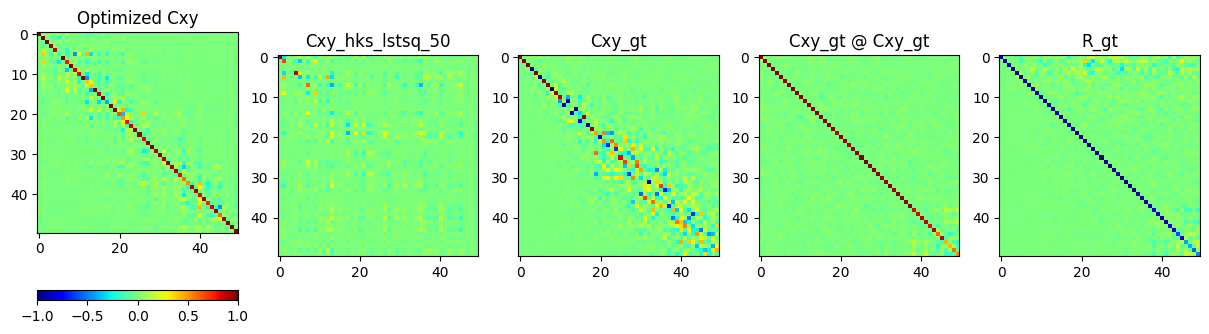

In [19]:
import matplotlib.pyplot as plt


print('Descriptor preservation error')

print('C_est', 0.5 * np.sum(np.square(Cxy_opt @ evecs_trans_x @ hks_x_np - evecs_trans_y @ hks_y_np)))
print('C_hks', 0.5 * np.sum(np.square(Cxy_hks_lstsq_50.numpy() @ evecs_trans_x @ hks_x_np - evecs_trans_y @ hks_y_np)))
print('C_gt', 0.5 * np.sum(np.square(Cxy_gt @ evecs_trans_x @ hks_x_np - evecs_trans_y @ hks_y_np)))


fig, ax = plt.subplots(1, 5, figsize=(15, 5))

ax_0 = ax[0].imshow(Cxy_opt, cmap='jet', vmin=-1, vmax=1)
ax[0].set_title('Optimized Cxy')
# add colorbar
ax_cbar = fig.colorbar(ax_0, ax=ax[0], orientation='horizontal')

ax_1 = ax[1].imshow(Cxy_hks_lstsq_50, cmap='jet', vmin=-1, vmax=1)
ax[1].set_title('Cxy_hks_lstsq_50')
# add colorbar
# ax_cbar = fig.colorbar(ax_1, ax=ax[1], orientation='horizontal')

ax_2 = ax[2].imshow(Cxy_gt, cmap='jet', vmin=-1, vmax=1)
ax[2].set_title('Cxy_gt')
# add colorbar
# ax_cbar = fig.colorbar(ax_2, ax=ax[2], orientation='horizontal')

ax_3 = ax[3].imshow(Cxy_gt.T @ Cxy_gt, cmap='jet', vmin=-1, vmax=1)
ax[3].set_title('Cxy_gt @ Cxy_gt')
# ax_cbar = fig.colorbar(ax_3, ax=ax[3], orientation='horizontal')

ax_4 = ax[4].imshow(R_gt, cmap='jet', vmin=-1, vmax=1)
ax[4].set_title('R_gt')
# ax_cbar = fig.colorbar(ax_4, ax=ax[4], orientation='horizontal')


plt.show()

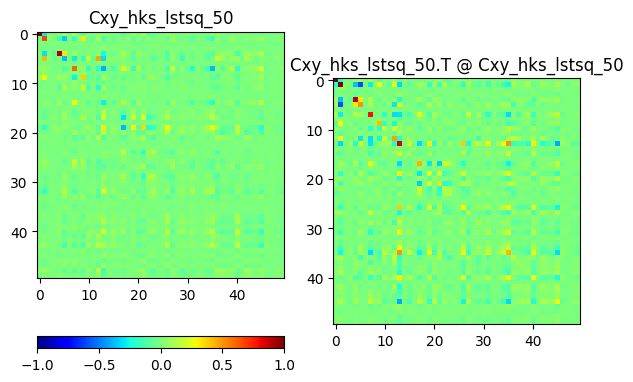

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(7, 5))

ax_0 = ax[0].imshow(Cxy_hks_lstsq_50, cmap='jet', vmin=-1, vmax=1)
ax[0].set_title('Cxy_hks_lstsq_50')
# add colorbar
ax_cbar = fig.colorbar(ax_0, ax=ax[0], orientation='horizontal')

ax_1 = ax[1].imshow(Cxy_hks_lstsq_50.T @ Cxy_hks_lstsq_50, cmap='jet', vmin=-1, vmax=1)
ax[1].set_title('Cxy_hks_lstsq_50.T @ Cxy_hks_lstsq_50')

plt.show()

In [21]:
import utils.fmap_util as fmap_util
import metrics.geodist_metric as geodist_metric


def compare_with_gt(
    Cxy_est, Cxy_gt,
    evecs_x, evecs_y,
    evecs_trans_x, evecs_trans_y,
    verts_x, verts_y,
    corr_x, corr_y
    ):
    
    # hard correspondence 
    p2p_gt = fmap_util.fmap2pointmap(
        Cxy_gt,
        evecs_x,
        evecs_y,
        )
    p2p_est = fmap_util.fmap2pointmap(
        Cxy_est,
        evecs_x,
        evecs_y,
        )
    
    # soft correspondence
    Pyx_gt = evecs_y @ Cxy_gt @ evecs_trans_x
    Pyx_est = evecs_y @ Cxy_est @ evecs_trans_x
    
    # distance matrices
    dist_x = torch.cdist(verts_x, verts_x)
    dist_y = torch.cdist(verts_y, verts_y)

    # geodesic error
    geo_err_gt = geodist_metric.calculate_geodesic_error(dist_x, corr_x, corr_y, p2p_gt, return_mean=False)    
    geo_err_est = geodist_metric.calculate_geodesic_error(dist_x, corr_x, corr_y, p2p_est, return_mean=False)
    
    # print results
    print(f'Cxy_est - Cxy_gt: {torch.sum(torch.abs(Cxy_est - Cxy_gt)):.2f}')
    print(f'Pyx_est - Pyx_gt: {torch.sum(torch.abs(Pyx_est - Pyx_gt)):.2f}')
    print(f'Geodesic error GT: {geo_err_gt.abs().sum():.2f}, EST: {geo_err_est.abs().sum():.2f}')
    
    
print('------ Cxy_opt')
compare_with_gt(
    torch.tensor(Cxy_opt, dtype=torch.float32),
    data['Cxy'][:50, :50],
    data_x['evecs'][:, :50],
    data_y['evecs'][:, :50],
    data_x['evecs_trans'][:50, :],
    data_y['evecs_trans'][:50, :],
    data_x['verts'],
    data_y['verts'],
    data_x['corr'],
    data_y['corr']
    )    

print('\n------ Cxy_hks_lstsq, 50 ef')
compare_with_gt(
    Cxy_hks_lstsq_50,
    data['Cxy'][:50, :50],
    data_x['evecs'][:, :50],
    data_y['evecs'][:, :50],
    data_x['evecs_trans'][:50, :],
    data_y['evecs_trans'][:50, :],
    data_x['verts'],
    data_y['verts'],
    data_x['corr'],
    data_y['corr']
    )
    
print('\n------ Cxy_hks_lstsq, 200 ef')
compare_with_gt(
    Cxy_hks_lstsq,
    data['Cxy'],
    data_x['evecs'],
    data_y['evecs'],
    data_x['evecs_trans'],
    data_y['evecs_trans'],
    data_x['verts'],
    data_y['verts'],
    data_x['corr'],
    data_y['corr']
    )

print('\n------ Cxy_wks_lstsq, 50 ef')
compare_with_gt(
    Cxy_wks_lstsq[:50, :50],
    data['Cxy'][:50, :50],
    data_x['evecs'][:, :50],
    data_y['evecs'][:, :50],
    data_x['evecs_trans'][:50, :],
    data_y['evecs_trans'][:50, :],
    data_x['verts'],
    data_y['verts'],
    data_x['corr'],
    data_y['corr']
    )

print('\n------ Cxy_wks_lstsq, 200 ef')
compare_with_gt(
    Cxy_wks_lstsq,
    data['Cxy'],
    data_x['evecs'],
    data_y['evecs'],
    data_x['evecs_trans'],
    data_y['evecs_trans'],
    data_x['verts'],
    data_y['verts'],
    data_x['corr'],
    data_y['corr']
    )

------ Cxy_opt
Cxy_est - Cxy_gt: 168.57
Pyx_est - Pyx_gt: 29995.76
Geodesic error GT: 92.73, EST: 1555.89

------ Cxy_hks_lstsq, 50 ef
Cxy_est - Cxy_gt: 163.53
Pyx_est - Pyx_gt: 19024.93
Geodesic error GT: 92.73, EST: 1108.12

------ Cxy_hks_lstsq, 200 ef
Cxy_est - Cxy_gt: 1336.24
Pyx_est - Pyx_gt: 23535.19
Geodesic error GT: 46.61, EST: 974.55

------ Cxy_wks_lstsq, 50 ef
Cxy_est - Cxy_gt: 284.54
Pyx_est - Pyx_gt: 51919.43
Geodesic error GT: 92.73, EST: 1190.73

------ Cxy_wks_lstsq, 200 ef
Cxy_est - Cxy_gt: 1708.99
Pyx_est - Pyx_gt: 67802.25
Geodesic error GT: 46.61, EST: 1332.32
